## Open notebook in:
| Colab                                 
:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nicolepcx/transformers-the-definitive-guide/blob/master/CH03/ch03_segment_videos_with_sam2.ipynb)                                             

# About this Notebook

This notebook demonstrates **interactive video object segmentation** using **SAM2 (Segment Anything Model 2)**, the latest video segmentation architecture developed by Meta. SAM2 extends the capabilities of the original Segment Anything Model to handle **stateful video segmentation**, enabling point- and box-based prompting, tracking of multiple objects, and efficient inference across entire video sequences.

### Steps Included:

1. **Environment Setup**:
   The notebook is designed to run on Google Colab. It installs dependencies including OpenCV, `matplotlib`, `supervision`, `gdown`, and `sam2`. It also sets up a mixed-precision computing environment using `bfloat16` and optionally `TF32` on Ampere GPUs to accelerate inference.

2. **Model and Checkpoint Initialization**:
   The SAM2 video predictor is built using a YAML configuration and a pre-trained checkpoint (`sam2.1_hiera_large.pt`) downloaded from Meta's official release. The model is configured to run on CUDA, MPS, or CPU depending on availability.

3. **Video Preprocessing**:
   A sample video is downloaded and decomposed into JPEG frames using `ffmpeg`. These frames serve as the input format required by SAM2 for sequential inference.

4. **Stateful Inference Setup**:
   SAM2 requires a persistent inference state across frames for temporal coherence. The notebook initializes this state and prepares it for interactive annotation and tracking.

5. **Annotation and Prompting**:
   An interactive bounding box widget (`BBoxWidget`) is used to specify object locations in a reference frame (e.g., selecting a ball). This user-defined prompt is converted into SAM2’s internal format to guide segmentation.

6. **Interactive Point-Based Tracking**:
   The annotated points are used to guide the SAM2 model to identify and track the object across frames. The model outputs logits, which are thresholded into binary masks to produce segmentations for each frame.

7. **Result Visualization**:
   The notebook renders segmentation masks on top of the video frames, allowing you to visually inspect object tracking quality. Visualization is spaced across frames (e.g., every 20 frames) to provide a snapshot of tracking consistency throughout the video.

This notebook highlights the power of **stateful, point-driven video segmentation** using **foundation models**. It offers a practical introduction to building interactive segmentation tools for videos, ideal for applications such as **sports analytics**, **surveillance**, **robotics**, and **video editing**.


# Install dependencies

In [ ]:
using_colab = True

In [ ]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
CUDA is available: True
  Cloning https://github.com/facebookresearch/sam2.git to /tmp/pip-req-build-maycnqtt
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/sam2.git /tmp/pip-req-build-maycnqtt
  Resolved https://github.com/facebookresearch/sam2.git to commit 2b90b9f5ceec907a1c18123530e92e794ad901a4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
--2025-05-18 15:19:47--  https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.124, 108.157.254.121, 108.157.254.15, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.254.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 898083611 (856M) [application/vnd.snesdev-page-table]
Saving to: ‘../checkpoints/sam2.

In [ ]:
!pip install -q supervision

In [ ]:
!pip install -q gdown
!apt-get update
!apt-get install ffmpeg

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

In [ ]:
!pip install jupyter_bbox_widget -q

# Imports

In [ ]:
from sam2.build_sam import build_sam2_video_predictor
import cv2
import torch
import base64

import numpy as np
import supervision as sv

from pathlib import Path
from supervision.assets import download_assets, VideoAssets
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

# Get and process data

In [ ]:

file_id = "1g2a2-HLEuwWFMsoDD1iqTx2NBuiCDSDD"
!gdown $file_id --output movie_players.mp4


Downloading...
From: https://drive.google.com/uc?id=1g2a2-HLEuwWFMsoDD1iqTx2NBuiCDSDD
To: /content/movie_players.mp4
100% 2.43M/2.43M [00:00<00:00, 212MB/s]


In [ ]:
!mkdir -p frames
!ffmpeg -i movie_players.mp4 -q:v 2 -start_number 0 frames/%05d.jpg

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [ ]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


# Get the SAM2 checkpoint

In [ ]:
sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2_model = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [ ]:


IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

**NOTE:** This code enables mixed-precision computing for faster deep learning. It uses bfloat16 for most calculations and, on newer NVIDIA GPUs, leverages TensorFloat-32 (TF32) for certain operations to further boost performance.

## Preprocess video

## Download video and split it into frames

**NOTE:** SAM2 assumee that the video is stored as a list of JPEG frames with filenames like `<frame_index>.jpg`. Let's start by downloading a sample video, splitting it into frames, and saving them to disk. Feel free to replace `SOURCE_VIDEO` with the path to your video file.

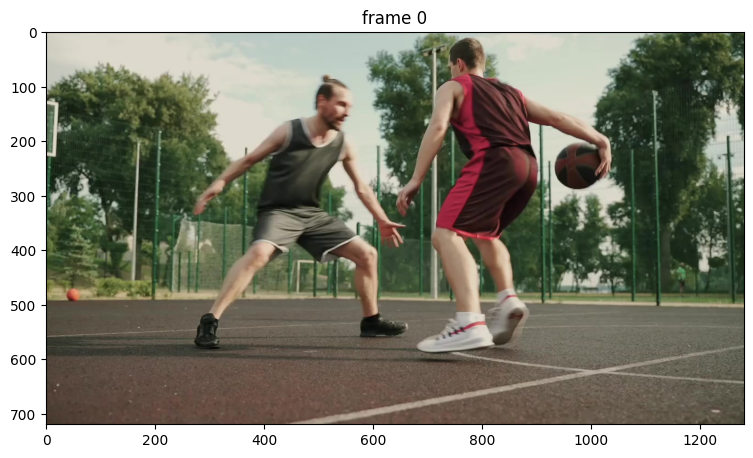

In [ ]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "./frames"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

## Initialize the inference state

**NOTE:** SAM 2 requires stateful inference for interactive video segmentation, so we need to initialize an inference state on this video. During initialization, it loads all the JPEG frames in `video_path` and stores their pixels in `inference_state` (as shown in the progress bar below).

In [ ]:
inference_state = sam2_model.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████| 332/332 [00:11<00:00, 29.88it/s]


If you have run any previous tracking using this inference_state, please reset it first via reset_state. (The cell below is just for illustration; it's not needed to call reset_state here as this inference_state is just freshly initialized above.)

In [ ]:
sam2_model.reset_state(inference_state)

### Prompting with points

In [ ]:
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

SAM2 allows tracking multiple objects at once. Update the `OBJECTS` list if you want to change the list of tracked objects.

In [ ]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

In [ ]:
OBJECT = ['ball']

In [ ]:
widget = BBoxWidget(classes=OBJECT)
widget.image = encode_image("/content/frames/00000.jpg")
widget

BBoxWidget(classes=['ball'], colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c…

The widget we are using stores annotations in a format that is inconsistent with SAM2's requirements. We parse them and then pass them to SAM2 via the `add_new_points` method. Each of the objects we track must be passed via a separate `add_new_points` call. It is important to specify `frame_idx` each time - the index of the frame to which the annotations relate, and `obj_id` - the ID of the object to which the annotations relate.

In [ ]:
default_box = [{'x': 995, 'y': 239, 'width': 0, 'height': 0, 'label': 'ball'}]

In [ ]:
box = widget.bboxes[0] if widget.bboxes else default_box[0]
# Convert box to point format expected by the model
points = np.array([[box['x'], box['y']]], dtype=np.float32)
points

array([[995., 239.]], dtype=float32)

# Video inference




Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).


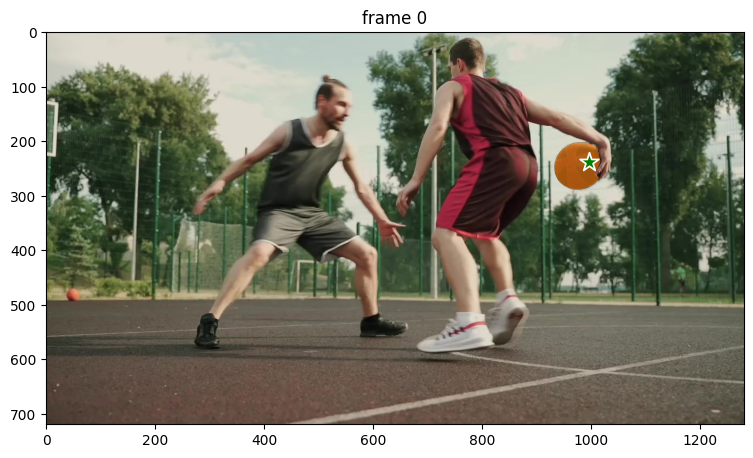

In [ ]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)


# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
_, out_obj_ids, out_mask_logits = sam2_model.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

propagate in video: 100%|██████████| 332/332 [00:15<00:00, 21.44it/s]


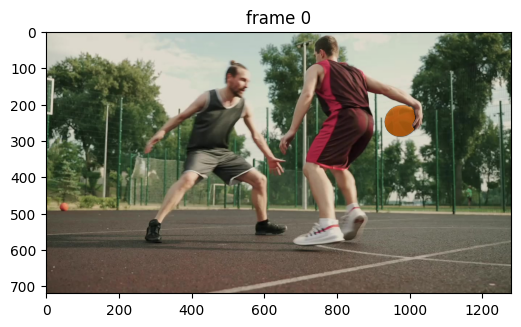

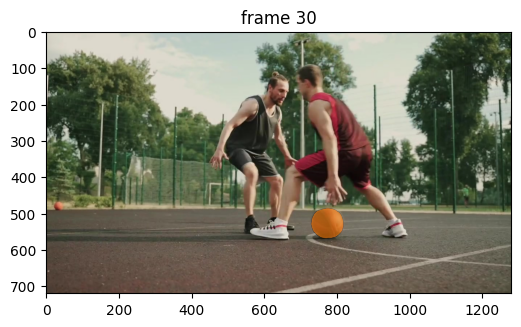

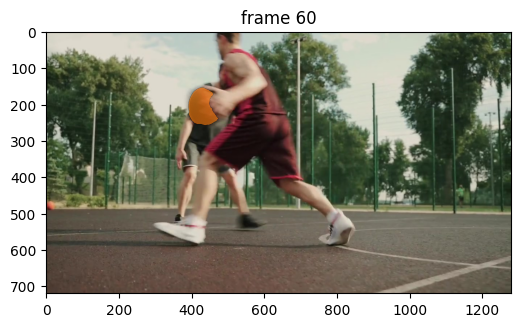

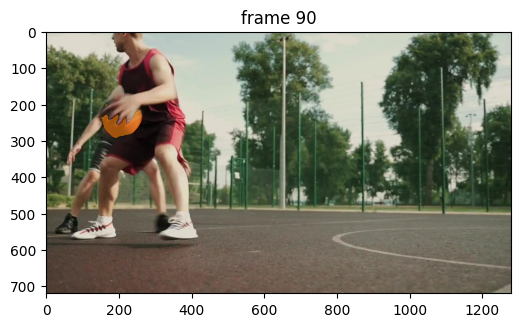

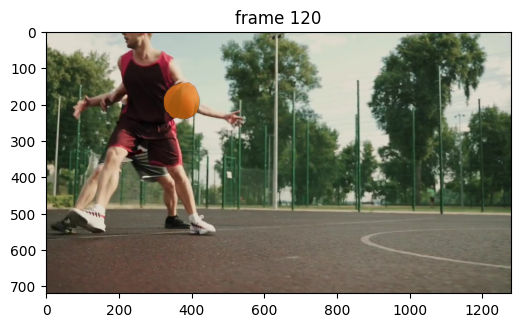

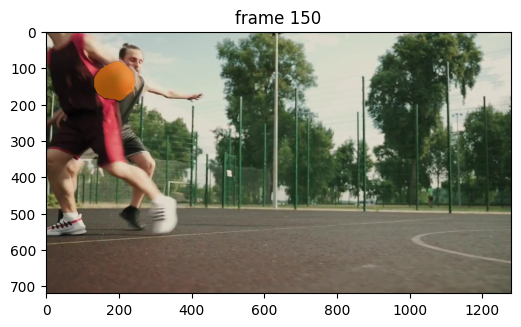

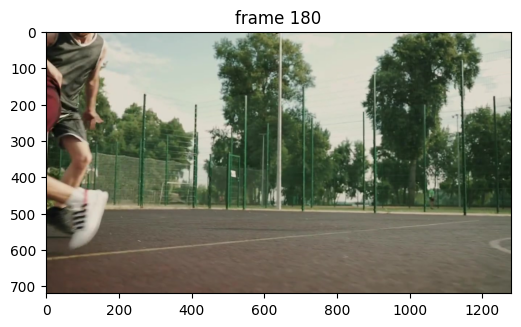

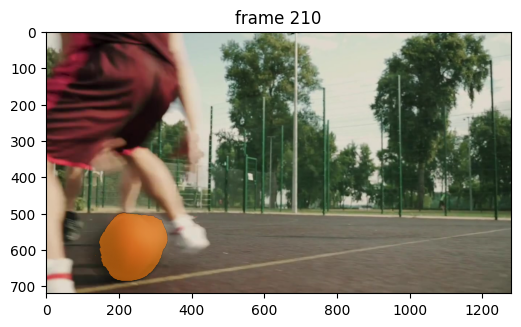

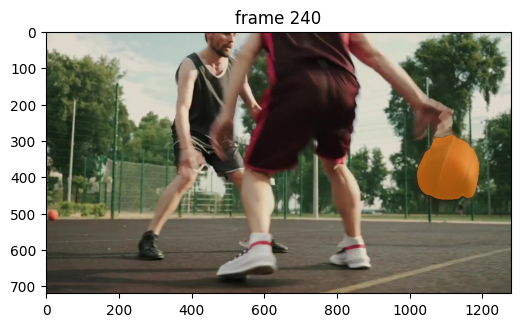

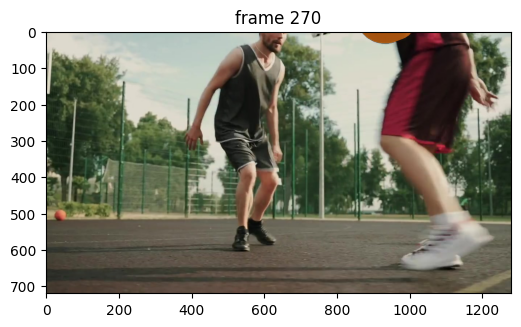

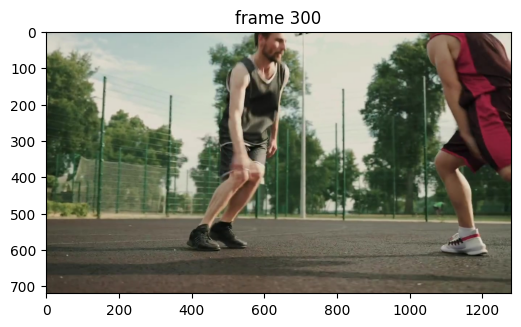

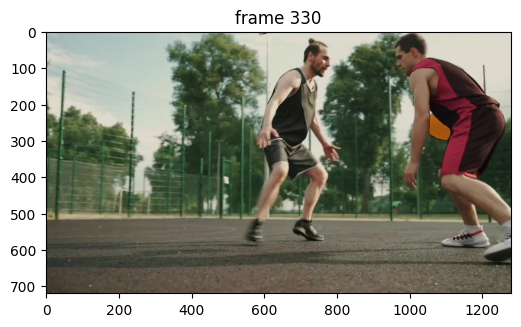

In [ ]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in sam2_model.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 20
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

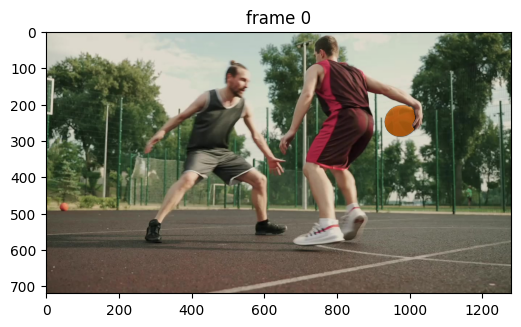

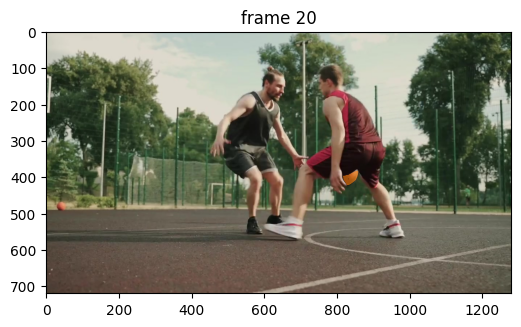

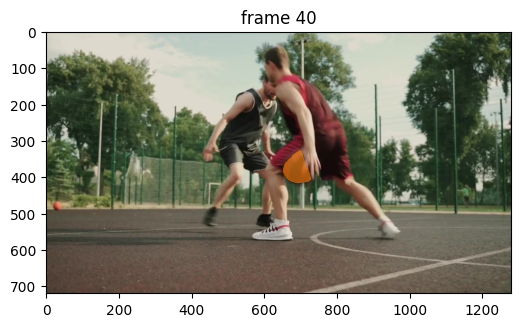

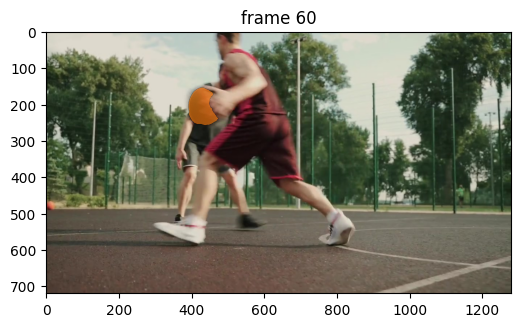

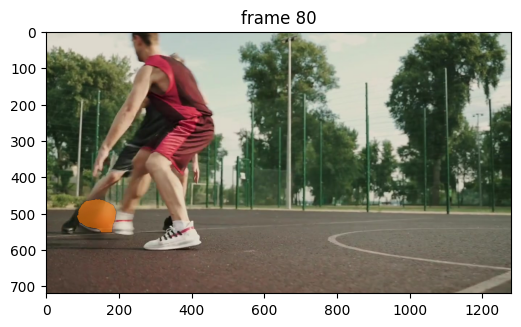

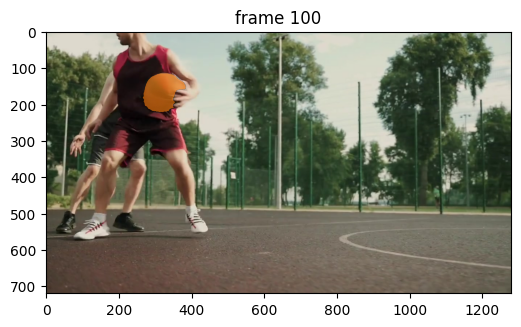

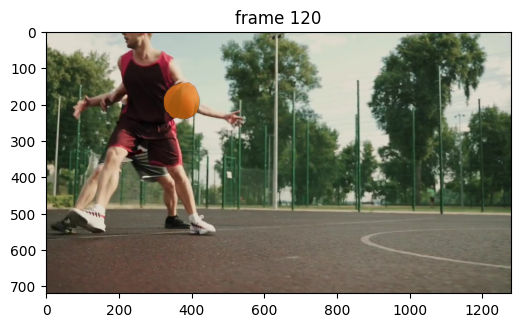

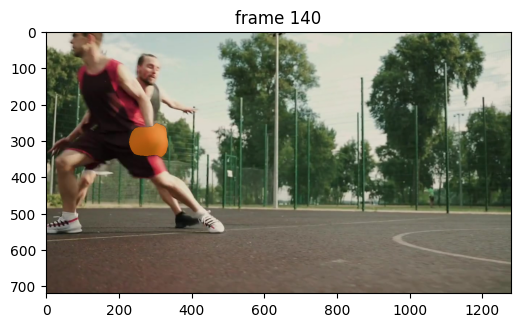

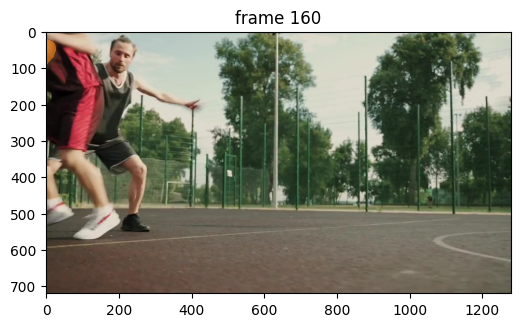

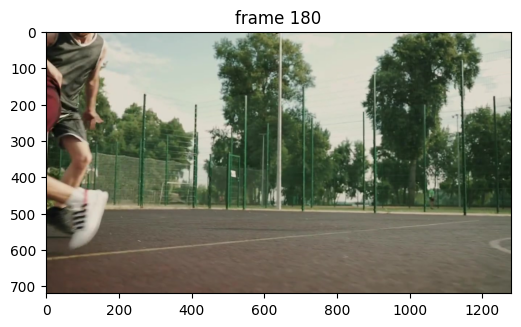

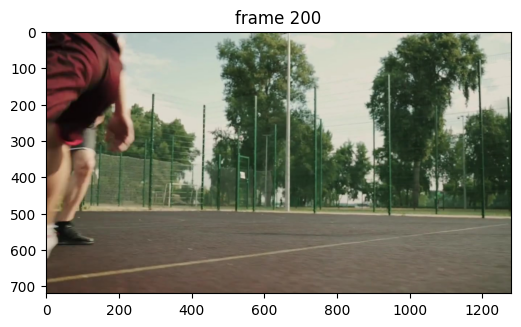

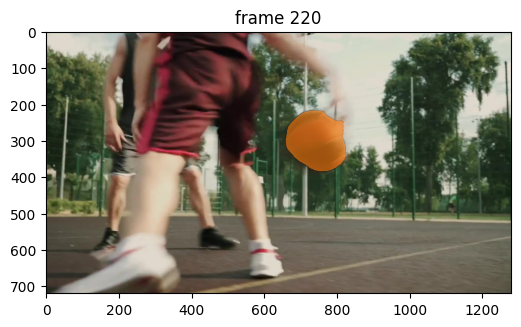

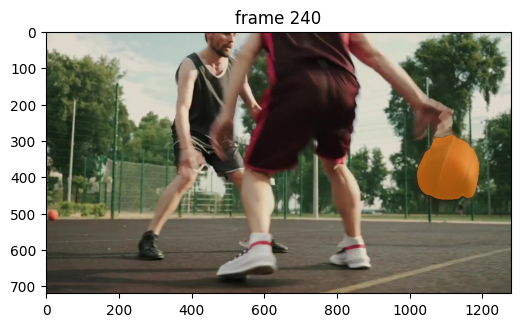

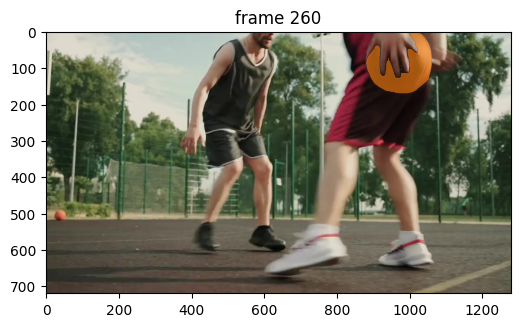

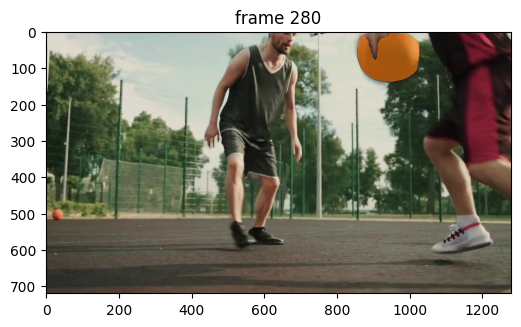

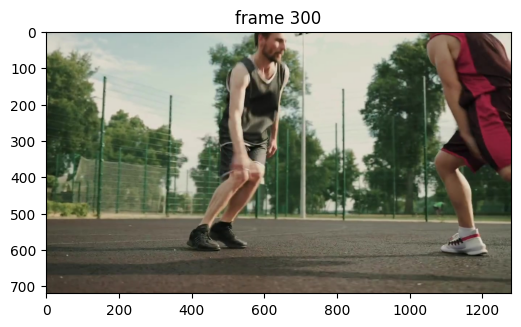

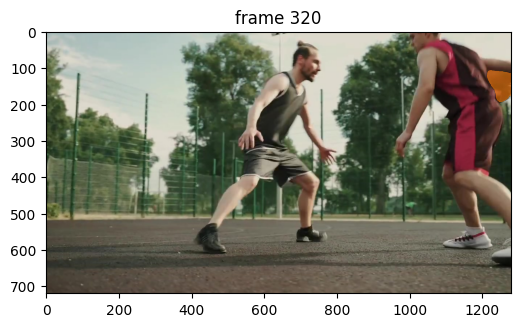

In [ ]:
# render the segmentation results every few frames
vis_frame_stride = 20
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)